In [1]:
# making trajectory visualizations prettier for the actual paper

import torch
import numpy as np
import matplotlib.pyplot as plt
from hydra import compose, initialize
from omegaconf import OmegaConf
import yaml

%load_ext autoreload
%autoreload 2
from dysts.flows import Lorenz

import sys

# sys.path.append("/om2/user/ostrow/NN_delay_embeddings/nn_delay_embeddings")
sys.path.append("/Users/mitchellostrow/Desktop/Projects/NN_delays/nn_delay_embeddings")
sys.path.append("/Users/mitchellostrow/Desktop/Projects/NN_delays")
from src.models import *
from train import gen_data


In [165]:
# lru path
# path = '/om2/user/ostrow/NN_delay_embeddings/nn_delay_embeddings/multirun/2024-05-18/15-35-39/2'

# path = "/Users/mitchellostrow/Desktop/Projects/NN_delays/LRU-05-21_19-38-52_5/"

# gpt path
# path = "/om2/user/ostrow/NN_delay_embeddings/nn_delay_embeddings/multirun/2024-05-16/17-47-03/151/"
# path = "/Users/mitchellostrow/Desktop/Projects/NN_delays/nn_delay_embeddings/outputs/2024-05-22/14-26-55"
# path = "/Users/mitchellostrow/Desktop/Projects/NN_delays/nn_delay_embeddings/multirun/2024-05-23/00-34-08/1"
path = "/Users/mitchellostrow/Desktop/Projects/NN_delays/nn_delay_embeddings/multirun/2024-05-23/00-34-08/2"

with open(f"{path}/.hydra/config.yaml") as f:
    cfg = OmegaConf.load(f)

cfg

{'model': {'model_name': 'GPT', 'kwargs': {'input_dim': 1, 'd_model': 100, 'n_head': 5, 'context_length': 500, 'mlp_hidden': 50, 'seed': None, 'temp': None, 'use_pe': 'pe_softmax', 'pe_type': 'learnable'}}, 'attractor': {'name': 'Lorenz', 'driven_noise': 0.0, 'dt': 0.01, 'observed_noise': 0.05, 'dim_observed': 0, 'resample': False}, 'data': {'time': 500, 'nsamples': 1000, 'batch_size': 10}, 'train': {'optimizer': 'AdamW', 'lr': 0.001, 'weight_decay': 0.0, 'epochs': 1000, 'loss': 'MSE', 'nsteps': 1, 'eval_nsteps': 50, 'schedule': True}, 'eval': {'nstep_eval': {'nsteps': 20, 'n_obs': 4, 'kl_bins': 100, 'spectral_smoothing': 4, 'spectral_cutoff': 200}, 'metrics': ['compute_all_pred_stats', 'eval_nstep', 'predict_hidden_dims_lm', 'predict_hidden_dims_mlp', 'noise_amplification'], 'neighbors_comparison': {'n_neighbors': 20}, 'noise_amp': {'k': 3, 'maxT': 10, 'normalize': True}, 'dyn_quants': {'traj_length': 100, 'ntrajs': 10, 'rtol': 0.001, 'atol': 1e-10}, 'predict_hiddens': {'linear_model_

In [166]:
epoch = 950
# load model
init_mod = {
    "RNN": RNN,
    "Mamba": Mamba,
    "S4": S4,
    "GPT": GPT,
    "LRU": LRU,
}  # bc eval wasn't working

model = init_mod[cfg.model.model_name](**cfg.model.kwargs)

model.load_state_dict(torch.load(f"{path}/{cfg.model.model_name}_{epoch}.pt"))

<All keys matched successfully>

In [167]:
model.eval()
model

GPT(
  (transformer): ModuleDict(
    (wte): Linear(in_features=1, out_features=100, bias=True)
    (wpe): Embedding(500, 100)
    (h): Block(
      (ln_1): LayerNorm()
      (attn): CausalSelfAttention(
        (kq): Linear(in_features=100, out_features=200, bias=True)
        (v): Linear(in_features=100, out_features=100, bias=True)
        (attn_out): Linear(in_features=100, out_features=100, bias=True)
      )
      (attn_out_resid_dummy): Identity()
      (ln_2): LayerNorm()
    )
    (mlp): MLP(
      (c_fc): Linear(in_features=100, out_features=50, bias=True)
      (gelu): GELU(approximate='none')
      (dropout): Dropout(p=0.0, inplace=False)
      (c_proj): Linear(in_features=50, out_features=1, bias=True)
    )
  )
)

In [25]:
cfg.data.nsamples = 100

In [35]:
cfg.attractor.observed_noise = 0.01

In [172]:
attractor, loader, all_data = gen_data(cfg)
all_data.shape

torch.Size([100, 500, 1])

In [37]:
dim_observed = cfg.attractor.dim_observed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [168]:
data = all_data[:, :, dim_observed : dim_observed + 1]

x = data[:, :-1]

x = x.to(device)
y = data[:, 1:].to(device)

y_pred, hiddens = model(x)
hiddens = hiddens.cpu().detach().numpy()
hiddens = np.concatenate([hiddens.real, hiddens.imag], axis=-1)
y_pred.shape, hiddens.shape

(torch.Size([100, 499, 1]), (100, 499, 200))

In [169]:
#Calculate MASE
from src.metrics import compute_all_pred_stats

compute_all_pred_stats(y_pred.detach().cpu(), y,cfg.model.kwargs.d_model)

{'MAE': tensor(0.0205),
 'MASE': tensor(0.0628),
 'MSE': tensor(0.0013),
 'R2': tensor(1.0000),
 'Correl': 0.9999894253745862,
 'AIC': tensor(-6.2308),
 'logMSE': tensor(-6.6317)}

0.0045880447


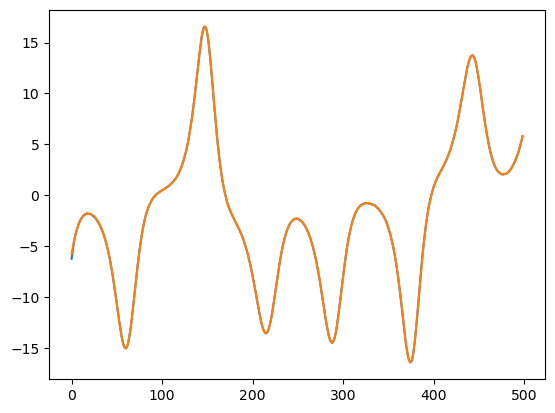

In [122]:
plt.plot(y_pred[0].detach().cpu().numpy(), label="pred")
plt.plot(y[0].detach().cpu().numpy(), label="true")
print(
    np.linalg.norm(y_pred.detach().cpu().numpy() - y.detach().cpu().numpy())
    / np.linalg.norm(y.detach().cpu().numpy())
)

In [159]:
# remove transient
hiddens = hiddens[:, 50:]

In [42]:
#do an actual delay embedding for comparison

import torch
import torch.nn as nn
import numpy as np


def embed_signal_torch(data, n_delays, delay_interval=1):
    """
    Create a delay embedding from the provided tensor data.

    Parameters
    ----------
    data : torch.tensor
        The data from which to create the delay embedding. Must be either:
        a 3-dimensional array/tensor of shape
        K x T x N where K is the number of "trials" and T and N are
        as defined above.

    n_delays : int
        Parameter that controls the size of the delay embedding. Explicitly,
        the number of delays to include.

    delay_interval : int
        The number of time steps between each delay in the delay embedding. Defaults
        to 1 time step.
    """
    if isinstance(data, np.ndarray):
        data = torch.from_numpy(data)
    device = data.device

    b, time, dim = data.shape
    if data.shape[int(data.ndim == 3)] - (n_delays - 1) * delay_interval < 1:
        raise ValueError(
            "The number of delays is too large for the number of time points in the data!"
        )

    # initialize the embedding
    embedding = torch.zeros((b, time, dim * n_delays)).to(device)

    for d in range(n_delays):

        ddelay = d * delay_interval

        ddata = d * dim
        delayed_data = data[:, : time - ddelay]
        # print(delayed_data.shape)

        embedding[:, ddelay:, ddata : ddata + data.shape[2]] = delayed_data

    return embedding



In [32]:
xH = x[:20]
nd = 10
dint = 2
H = embed_signal_torch(xH, nd, dint).numpy()
H = H[:,nd*dint:]
cfg.model.model_name = f"Delay Embedding, {nd} delays {dint} interval"
hiddens = H

torch.Size([20, 499, 1])
torch.Size([20, 497, 1])
torch.Size([20, 495, 1])
torch.Size([20, 493, 1])
torch.Size([20, 491, 1])
torch.Size([20, 489, 1])
torch.Size([20, 487, 1])
torch.Size([20, 485, 1])
torch.Size([20, 483, 1])
torch.Size([20, 481, 1])


In [51]:
#measure Participation ratio as we sweep delays and delay interval
from sklearn.decomposition import PCA
def get_pr(x):
    pca = PCA()
    d = hiddens.reshape(-1, hiddens.shape[-1])
    pca.fit(d)  
    evr = pca.explained_variance_
    pr = np.sum(evr)**2/np.sum(evr**2)
    return pr

ndelays = np.arange(1, 40)
dintervals = np.arange(1, 10)
prs = np.zeros((len(ndelays), len(dintervals))
)
for i, nd in enumerate(ndelays):
    for j, di in enumerate(dintervals):
        H = embed_signal_torch(xH, nd, di).numpy()
        H = H[:,nd*di:]
        hiddens = H
        prs[i,j] = get_pr(hiddens)
        print(i,j,prs[i,j])




NameError: name 'xH' is not defined

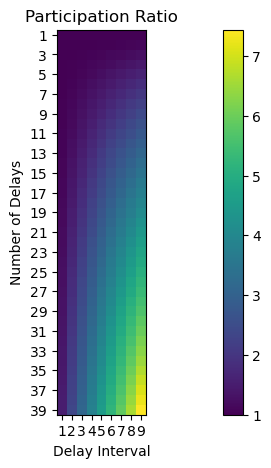

<Figure size 640x480 with 0 Axes>

In [46]:
plt.figure(figsize=(20,5))
plt.imshow(prs)
plt.colorbar()
plt.xlabel("Delay Interval")
plt.ylabel("Number of Delays")
plt.title("Participation Ratio")
plt.xticks(range(len(dintervals)),dintervals)
plt.yticks(range(0,len(ndelays),2),ndelays[::2])
plt.show()
plt.tight_layout()

In [171]:
data.shape

torch.Size([100, 500, 1])

In [174]:
from sklearn.decomposition import PCA
import matplotlib.cm as cm

# hiddens = all_data

pca = PCA(n_components=5)
d = hiddens.reshape(-1, hiddens.shape[-1])
red = pca.fit_transform(d)
print(pca.explained_variance_ratio_, np.cumsum(pca.explained_variance_ratio_))
#calculate participation ratio
evr = pca.explained_variance_
pr = np.sum(evr)**2/np.sum(evr**2)
print("PR",pr)
red = red.reshape(hiddens.shape[0], hiddens.shape[1], 5)
red.shape

[0.64365687 0.32004763 0.0362955 ] [0.64365687 0.9637045  1.        ]
PR 1.9303453751204518


ValueError: cannot reshape array of size 1500000 into shape (1000,500,5)

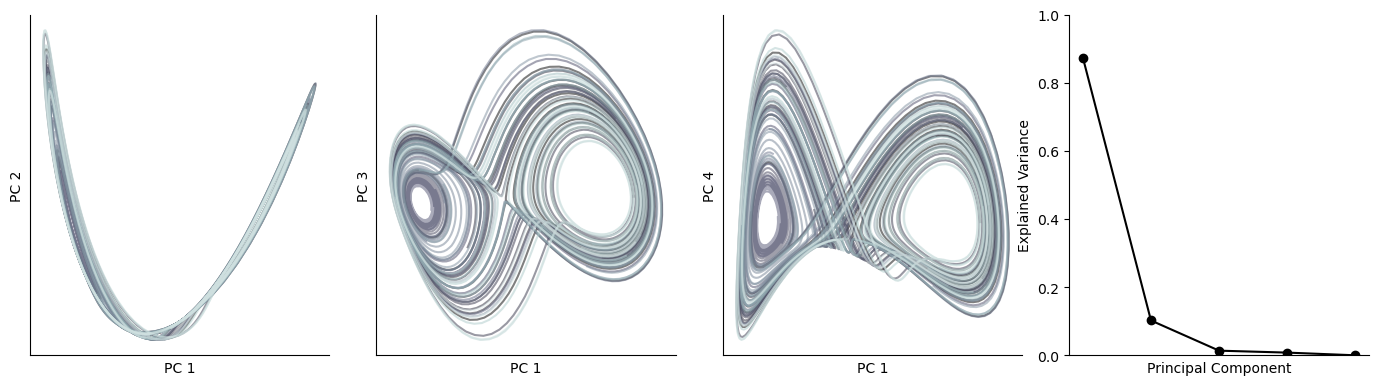

In [162]:
ntrajs = 20

cmap = cm.bone(np.linspace(0, 1, ntrajs+2))
# cmap = cm.copper(np.linspace(0, 1, ntrajs + 2))

npcs = 3

fig, ax = plt.subplots(1, npcs+1, figsize=(14, 4))
i = 0
ax = ax.reshape(1, npcs+1)
for j in range(npcs):
    for k in range(ntrajs):
        ax[0, j].plot(red[k, :, i], red[k, :, j+1], color=cmap[k], alpha=0.5)
    ax[0, j].set_xlabel(f"PC {i+1}")
    ax[0, j].set_ylabel(f"PC {j+2}")
    # ax[0, j].set_xlabel(f"dim {i+1}, EV {pca.explained_variance_ratio_[i]:.3f}")
    # ax[0, j].set_ylabel(f"dim {j+2}, EV {pca.explained_variance_ratio_[j+1]:.3f}")
    # remove top and right lines, as well as ticks
    ax[0, j].spines["top"].set_visible(False)
    ax[0, j].spines["right"].set_visible(False)
    ax[0, j].set_xticks([])
    ax[0, j].set_yticks([])

plt.tight_layout()
#move this title up a bit
# plt.suptitle(f"{cfg.model.model_name}", fontsize=20, y=1)
#plot evr on the last axis
ax[0,-1].plot(np.arange(1,pca.explained_variance_ratio_.shape[-1]+1),pca.explained_variance_ratio_, marker="o",c='k')
ax[0,-1].set_xlabel("Principal Component")
ax[0,-1].set_ylabel("Explained Variance")
#get rid of top and right spines
ax[0,-1].spines["top"].set_visible(False)
ax[0,-1].spines["right"].set_visible(False)
#get rid of digits in ticks but keep the ticks
ax[0,-1].set_xticks([])
ax[0,-1].set_ylim(0,1)

plt.savefig(f"{cfg.model.model_name}.pdf")